In [1]:
import time
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [1]:
import gym
import numpy as np
from gym import spaces, utils
from MAMEToolkit.emulator import Emulator
from MAMEToolkit.emulator import Address
from KofSteps import *
from KofActions import Actions
import cv2
import math
import random
import string

In [12]:
class RewardCalculator:
    def get_reward(self, info ,last_info):
        pass

class DefaultRewardCalculator(RewardCalculator):
    def __init__(self, distance_rate, time_rate, damage_rate):
        self.distance_rate = distance_rate
        self.time_rate = time_rate
        self.damage_rate = damage_rate

    def get_reward(self,info ,last_info):
        p1_diff = (last_info["healthP1"] - info["healthP1"])
        p1_diff = 0 if p1_diff < 0 else p1_diff
        p2_diff = (last_info["healthP2"] - info["healthP2"])
        p2_diff = 0 if p2_diff < 0 else p2_diff
        damage_reward = (p2_diff-p1_diff )* self.damage_rate
        distance = np.abs(info["1P_x"] - info["2P_x"])
        #print(distance)
        if distance <= 150:
            distance = 0
        else:
            distance = distance -150

        distance_reward = - distance* self.distance_rate
        time_reward = -1 * self.time_rate
        #print(f"damage_reward:{damage_reward}, distance_reward:{distance_reward},time_reward{time_reward}")
        reward = damage_reward + distance_reward + time_reward
        #print(f"reward: {reward}")
        return reward

class ComboRewardCalculator(DefaultRewardCalculator):
    def __init__(self, distance_rate, time_rate, damage_rate):
        super(ComboRewardCalculator, self).__init__(distance_rate, time_rate, damage_rate)

    def get_reward(self,info ,last_info):
        p1_diff = (last_info["healthP1"] - info["healthP1"])
        p1_diff = 0 if p1_diff < 0 else p1_diff
        p2_diff = (last_info["healthP2"] - info["healthP2"])
        p2_diff = 0 if p2_diff < 0 else p2_diff
        combo = info["2P_combo"]

        damage_reward = (p2_diff-p1_diff )* self.damage_rate * (1 if combo == 0 else math.exp(combo-1))
        print(combo,math.exp(combo-1),p2_diff-p1_diff ,damage_reward )
        distance = np.abs(info["1P_x"] - info["2P_x"])
        #print(distance)
        if distance <= 150:
            distance = 0
        else:
            distance = distance -150

        distance_reward = - distance* self.distance_rate

        time_reward = -1 * self.time_rate
        info["damage_reward"] = damage_reward
        info["distance_reward"] = distance_reward
        info["time_reward"] = time_reward
        #print(f"combo:{combo}, damage_reward:{damage_reward}, distance_reward:{distance_reward},time_reward{time_reward}")
        reward = damage_reward + distance_reward + time_reward
        #print(f"reward: {reward}")
        return reward

class Kof98Environment(gym.Env):
    MAX_VELOCITY = 30
    move_actions = {
            0: [Actions.P1_LEFT],
            1: [Actions.P1_LEFT, Actions.P1_UP],
            2: [Actions.P1_UP],
            3: [Actions.P1_UP, Actions.P1_RIGHT],
            4: [Actions.P1_RIGHT],
            5: [Actions.P1_RIGHT, Actions.P1_DOWN],
            6: [Actions.P1_DOWN],
            7: [Actions.P1_DOWN, Actions.P1_LEFT],
            8: []
        }

    attack_actions = {
        0: [Actions.P1_A],
        1: [Actions.P1_B],
        2: [Actions.P1_C],
        3: [Actions.P1_D],
        4: [Actions.P1_A, Actions.P1_B],
        5: [Actions.P1_C, Actions.P1_D],
        6: [Actions.P1_A, Actions.P1_B, Actions.P1_C],
        7: [Actions.P1_A, Actions.P1_B, Actions.P1_C, Actions.P1_D],
        8: []
    }
    @staticmethod
    def setup_memory_addresses():
        return {
            "playing": Address('0x10A83E', 'u8'),
            "input": Address('0x300000', 'u8'),
            "2Frame": Address('0x10DA44', 'u8'),
            "healthP1": Address('0x108239', 'u8'),
            "healthP2": Address('0x108439', 'u8'),
            "1P_x": Address('0x108118', 'u16'),
            "1P_y": Address('0x108120', 'u16'),
            "1P_pow_value": Address('0x1081e8', 'u8'),
            "1P_pow_state": Address('0x10825f', 'u8'), #0-3 bits, power start count.
                                                     # 4-7 bits, max state: 00, off, 10. start, 20, in max power, 30 off
            "1P_combo": Address('0x1082ce', 'u8'), # 1P be comboed count


            "2P_x": Address('0x108318', 'u16'),
            "2P_y": Address('0x108320', 'u16'),
            "2P_pow_value": Address('0x1083e8', 'u8'),
            "2P_pow_state": Address('0x10845f', 'u8'),
            "2P_combo": Address('0x1084ce', 'u8'), # 2P be comboed count
            "background1_x": Address('0x10b0ca', 'u16'),
            "1P_Action": Address('0x108172', 'u16'),
            "2P_Action": Address('0x108372', 'u16'),

            # action sequence
            "action_seq_1": Address('0x10E7B8', 'u64'),
            "action_seq_2": Address('0x10E7C0', 'u64'),
            "action_seq_3": Address('0x10E7C8', 'u64'),
            "action_seq_4": Address('0x10E7D0', 'u64'),
        }
    def __init__(self,roms_path="roms/", rewardCalculator:RewardCalculator = ComboRewardCalculator(distance_rate = 0.01, time_rate = 0.01, damage_rate = 1),render=True):
        env_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=15))
        action_space_dic = {}
        action_space_dic.update(self.move_actions)
        index = len(self.move_actions)
        for i in range(0,4):
            for j in range(0,len(self.move_actions)):
                #print(j)
                action_space_dic[index] = self.move_actions[j].copy()+self.attack_actions[i]
                index = index +1
        action_space_dic[index] = [Actions.P1_LEFT,Actions.P1_A, Actions.P1_B]
        index = index + 1
        action_space_dic[index] = [Actions.P1_RIGHT, Actions.P1_A, Actions.P1_B]
        index = index + 1
        action_space_dic[index] = [Actions.P1_A, Actions.P1_B, Actions.P1_C]
        index = index + 1
        action_space_dic[index] = [Actions.P1_A, Actions.P1_B, Actions.P1_C, Actions.P1_D]
        self.action_space_dic = action_space_dic
        self.action_space = spaces.Discrete(len(action_space_dic))
        observation_space_dim = 0
        observation_space_dim+= 9 # health, x, y , pow, pow star,  MAX Mode, combo
        observation_space_dim+= 512 # action space
        observation_space_dim = observation_space_dim * 2 # 1P, 2P
        observation_space_dim += 1 # towards, 0 left, 1 right
        observation_space_dim += (12*8) # input sequence, 8bits, 12 step
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(observation_space_dim, ), dtype=np.float32)
        self.emu = Emulator(env_id, roms_path, "kof97", Kof98Environment.setup_memory_addresses(),debug=True,frame_ratio=2,render=render)
        self.rewardCalculator = rewardCalculator

    def reset(self):
        #self.emu.console.writeln('manager:machine():load("/home/duhuaiyu/kof97save_CH0_1")')
        self.emu.console.writeln('manager:machine():load("/home/duhuaiyu/KOF97Saves/CH0/kof97save_CH_W6A0DZ4W6R7Y5CM")')
        #self.emu.console.writeln('manager:machine():load("/home/duhuaiyu/kof97save02")')
        return self.preprocess(self.wait_for_fight_start())
    def render(self, mode="human"):
        if mode == "human":
            observation = self.observation
            image = np.zeros((130,310,3), np.uint8)
            image.fill(255)
            # print(image)
            thickness = 1
            offset = 9
            black_color = (0, 0, 0)
            color_1p = (255, 0, 0)
            color_2p = (0,255,0)
            # draw health bar
            image = cv2.rectangle(image,(5, 5) , (105,10), black_color, thickness)
            image = cv2.rectangle(image,(195, 5) , (295,10), black_color, thickness)
            image = cv2.rectangle(image,(5, 5) , (5+int(observation[0]*100),10), black_color, -1)
            image = cv2.rectangle(image,(195, 5) , (195+int(observation[0+offset]*100),10), black_color, -1)


            # draw location
            h_0 = 110
            w_0 = 5
            #1P
            x_1p = w_0+int(observation[1] * 300)
            y_1p = h_0 - int(observation[2] * 100)
            image = cv2.circle(image, (x_1p,y_1p), 3, color_1p, -1)
            image = cv2.putText(image,str(np.argmax(observation[18:18+512])) ,(x_1p,y_1p - 5),font,fontScale,black_color,1)
            #print(observation[7],observation[8]  )
            cv2.line(image,(x_1p,y_1p),(int(x_1p+observation[7]*Kof98Environment.MAX_VELOCITY) ,int(y_1p-observation[8]*Kof98Environment.MAX_VELOCITY) ),color_2p)

            x_2p = w_0+int(observation[1+offset] * 300)
            y_2p = h_0 - int(observation[2+offset] * 100)
            image = cv2.circle(image, (x_2p,y_2p), 3, color_2p, -1)
            image = cv2.putText(image,str(np.argmax(observation[531:531+512])),(x_2p,y_2p - 5),font,fontScale,black_color,1)
            cv2.line(image,(x_2p,y_2p),(int(x_2p+observation[7+offset]*Kof98Environment.MAX_VELOCITY) ,int(y_2p-observation[8+offset]*Kof98Environment.MAX_VELOCITY) ),color_2p)

            # draw pow
            y_start = 115
            image = cv2.rectangle(image,(5, y_start+5) , (105,y_start+10), black_color, thickness)
            image = cv2.rectangle(image,(195, y_start+5) , (295,y_start+10), black_color, thickness)
            image = cv2.circle(image, (110,y_start+7), 3, black_color, 1 if observation[5] == 0 else -1)
            #print(observation[4])
            if int(observation[4]) == 1:
                image = cv2.putText(image,"Max",(5,y_start),font,fontScale,black_color,1)

            image = cv2.rectangle(image,(5, y_start+5) , (5+int(observation[3]*100),y_start+10), black_color, -1)
            image = cv2.rectangle(image,(195, y_start+5) , (195+int(observation[3+offset]*100),y_start+10), black_color, -1)

            image = cv2.circle(image, (300,y_start+7), 3, black_color,1 if observation[5+offset] == 0 else -1)
            if int(observation[4+offset]) == 1:
                image = cv2.putText(image,"Max",(195,y_start),font,fontScale,black_color,1)

            # combo
            y_start = 50
            #print(observation[6],observation[6+offset])
            if int(observation[6]) == 1:
                image = cv2.putText(image,"Combo",(250,y_start),font,fontScale,black_color,1)
            if int(observation[6+offset]) == 1:
                image = cv2.putText(image,"Combo",(50,y_start),font,fontScale,black_color,1)
            #print(observation[18])
            print(f"1P act:{self.last_info['1P_Action']}, health: {self.last_info['healthP1']}, loc:({self.last_info['1P_x']},{self.last_info['1P_y']}), energy {self.last_info['1P_pow_value']}, reward:{self.last_info['reward']}")
            print(f"2P act:{self.last_info['2P_Action']}, health: {self.last_info['healthP2']}, loc:({self.last_info['2P_x']},{self.last_info['2P_y']}), energy {self.last_info['2P_pow_value']} ,toward:{self.last_info['toward']}")
            image = cv2.putText(image,"->" if observation[18] == 0 else "<-",(150,125),font,fontScale,black_color,1)
            return image
        else:
            print(f"1P act:{self.last_info['1P_Action']}, health: {self.last_info['healthP1']}, loc:({self.last_info['1P_x']},{self.last_info['1P_y']}), energy {self.last_info['1P_pow_value']}, reward:{self.last_info['reward']}")
            print(f"2P act:{self.last_info['2P_Action']}, health: {self.last_info['healthP2']}, loc:({self.last_info['2P_x']},{self.last_info['2P_y']}), energy {self.last_info['2P_pow_value']} ,toward:{self.last_info['toward']}")
            print(f" damage_reward:{self.last_info['damage_reward']}, distance_reward:{self.last_info['distance_reward']},time_reward:{self.last_info['time_reward']}")


    def step(self, action):
        actions = self.action_space_dic[action]
        data = self.sub_step(actions)
        done = self.check_done(data)
        reward = self.rewardCalculator.get_reward(data,self.last_info)
        data["reward"] = reward
        self.process_toward(data) # 0 left, 1 right, default 1P is facing right
        observation = self.preprocess(data)
        self.last_info = data
        return observation, reward, done, data

    def process_toward(self, data):
        last_toward = self.last_info["toward"]
        toward = last_toward
        if int(last_toward) == 0 :
            if data["1P_x"] <= data["2P_x"]:
                #print("1P<=2P")
                toward = 0
            else:
                #print("1P>2P")
                toward = 1
        else:
            if data["1P_x"] >= data["2P_x"]:
                #print("1P>=2P")
                toward = 1
            else:
                #print("1P<2P")
                toward = 0
        data["toward"] = toward
        #print(data["toward"],toward)
    def preprocess(self,data):
        observation = np.array([])
        observation = np.append(observation,[data["healthP1"]/103])
        observation = np.append(observation,[data["1P_x"]/736])
        observation = np.append(observation,[data["1P_y"]/120])
        observation = np.append(observation,[data["1P_pow_value"]/128])
        #print(data["1P_pow_value"],data["2P_pow_value"])
        pow_state_1p = data["1P_pow_state"]
        state, pow_num = divmod(pow_state_1p,16)
        #print(f"state {state},pow_num {pow_num}, {pow_state_1p}")
        observation = np.append(observation,[0 if state == 0 else 1])
        observation = np.append(observation,[0 if pow_num == 0 else 1])
        observation = np.append(observation,[0 if data["1P_combo"] == 0 else 1])
        # 1p velocity
        observation = np.append(observation,[(data["1P_x"] - self.last_info["1P_x"])/Kof98Environment.MAX_VELOCITY])
        observation = np.append(observation,[(data["1P_y"] - self.last_info["1P_y"])/Kof98Environment.MAX_VELOCITY])

        observation = np.append(observation,[data["healthP2"]/103])
        observation = np.append(observation,[data["2P_x"]/736])
        observation = np.append(observation,[data["2P_y"]/120])
        observation = np.append(observation,[data["2P_pow_value"]/128])
        pow_state_2p = data["2P_pow_state"]
        state, pow_num = divmod(pow_state_2p,16)
        observation = np.append(observation,[0 if state == 0 else 1])
        observation = np.append(observation,[0 if pow_num == 0 else 1])
        observation = np.append(observation,[0 if data["2P_combo"] == 0 else 1])
        # 1p velocity
        observation = np.append(observation,[(data["2P_x"] - self.last_info["2P_x"])/Kof98Environment.MAX_VELOCITY])
        observation = np.append(observation,[(data["2P_y"] - self.last_info["2P_y"])/Kof98Environment.MAX_VELOCITY])


        observation = np.append(observation,[data["toward"]])
        observation = np.append(observation,self.one_hot(512,data["1P_Action"]))
        observation = np.append(observation,self.one_hot(512,data["2P_Action"]))
        observation = np.append(observation,self.process_action_sequence(data))
        self.observation = observation
        return observation
    def int_to_b_array(self,value):
        return [int(x) for x in bin(value)[2:].zfill(8)]

    def process_action_sequence(self,info):
        res = []
        for i in range(4,0,-1):
            action_seq = info["action_seq_"+str(i)]
            #print(hex(action_seq))
            for _ in range(0,8):
                res.append(action_seq%64)
                action_seq = action_seq >>8
        binary_res = []
        last_action = None
        same_count = 0
        #print(res)
        keeped_count = 0
        for action in res:
            if keeped_count>=12:
                break
            if action == last_action and same_count<=2:
                same_count +=1
            else:
                binary_res.append(self.int_to_b_array(action))
                same_count = 0
                keeped_count +=1
            last_action = action
        #binary_res.reverse()
        for i in range(len(binary_res),12):
            binary_res.append([0,0,0,0,0,0,0,0])
        return list(np.array(binary_res).flat)

    def one_hot(self, num, index):
        res = np.zeros(num)
        res[index] = 1
        return res

    def wait_for_fight_start(self):
        data = self.emu.step([])
        # print("playing", data["playing"], 'healthP1',
        #       data["healthP1"], 'healthP2', data["healthP2"])
        i = 0
        while data["playing"] != 32:
            # if i % 2 == 1 :
            #     data = self.emu.step([Actions.P1_LEFT.value])
            # else:
            #     data = self.emu.step([Actions.P1_LEFT.value,Actions.P1_A.value])
            data = self.emu.step([])
            i = i +1
        data["reward"] = 0
        data["toward"] = 0
        data["damage_reward"] = 0
        data["distance_reward"] = 0
        data["time_reward"] = 0
        self.last_info = data
        return data
    def sub_step(self, actions):
        data = self.emu.step([action.value for action in actions])
        return data
    def check_done(self, data):
        if data["playing"] == 32:
            return False
        else:
            return True

In [2]:
from Kof97EnvironmentSR import Kof98EnvironmentLSTM

In [3]:
roms_path = "roms/"
env = Kof98EnvironmentLSTM()
obs = env.reset()

env_id:8830NPRWWP38KIA
b'\x1b[MAME]\x1b> nil\n'
b'\x1b[MAME]\x1b> sol.lua_engine::addr_space: 0xeae90c8\n'
b'\x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> RGB32 - 32bpp 8-8-8 RGB\n'
b'\x1b[MAME]\x1b> 320\n'
b'\x1b[MAME]\x1b> 224\n'


/home/duhuaiyu/anaconda3/envs/torch37cuda11/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
LOSE
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
LOSE
WIN
WIN
WIN
WIN
WIN
WIN
LOSE
WIN
WIN
LOSE
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
WIN
[-77.64000176265836, -4.350001310929656, -61.249999329447746, 72.1799968779087, 55.62999837473035, 44.10999650135636, 61.48999644443393, 56.32999745756388, 29.989997738972306, -14.98000255599618, 16.159997483715415, -20.25000256486237, -18.06000091508031, 34.47999633103609, 127.60999717377126, 41.209998451173306, -83.60000198334455, 73.98999810777605, 66.56999665312469, 23.299996696412563, 34.25999844260514, -47.679999170824885, -56.760001139715314, 52.60999791696668, -1.0000023115426302, 80.32999772578478, -29.260000724345446, 88.94999757781625, 9.909998884424567, -97.39000348746777, 99.8399976529181, -23.790001451969147, -8.190000282600522, 61.699999092146754, 81.81999724917114, 43.76999993622303, -60.89999910257757, 25.929997857660055, 99.2199974283576, -83.84000263363123, 69.949996

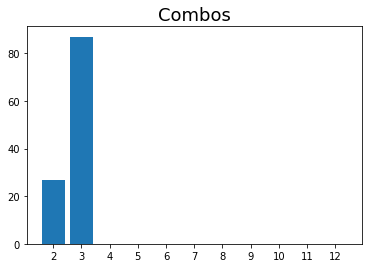

In [6]:
from typing import Any, Dict

import gym
import torch as th
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import Video
from stable_baselines3.common.logger import TensorBoardOutputFormat
from datetime import datetime
import matplotlib.pyplot as plt
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
from stable_baselines3.common.logger import Figure
win_episodes = []
_n_eval_episodes = 50
combos={i: 0 for i in range(2,13)}
#model_name = "Kof97_CH0_1"
#model_name = "Kof97_PPO_P1"
#model_name = "Kof97_1500000_2022-04-30"
# model_name = "Kof97_PPO_V2"
# model = PPO.load(model_name, env=env)

model_name = "Kof97_PPO_LSTM_V1"
model = RecurrentPPO.load(model_name, env=env)
#model = PPO.load("Kof97_PPO_P1", env=env)
screens = { i : [] for i in range(0,_n_eval_episodes) }
def eval_callback(_locals: Dict[str, Any], _globals: Dict[str, Any]) -> None:
    """
    Renders the environment in its current state, recording the screen in the captured `screens` list

    :param _locals: A dictionary containing all local variables of the callback's scope
    :param _globals: A dictionary containing all global variables of the callback's scope
    """
    # statistic combos
    combo_num = _locals["info"]["2P_combo"]
    if combo_num == 0 and _globals.get("combo_num") is not None and _globals.get("combo_num") > 0:
        combos[_globals.get("combo_num")] +=1
    _globals["combo_num"] = combo_num
    current_episode = _locals["episode_counts"][0]
    screen = env.render(mode="rgb_array")
    # PyTorch uses CxHxW vs HxWxC gym (and tensorflow) image convention
    screens[current_episode].append(screen)
    # statistic win_loss
    if _locals["dones"][0]:
        print(_locals["info"].get("win_loss") )
        if _locals["info"].get("win_loss") == "WIN":
            win_episodes.append(current_episode)


mean_reward, std_reward = evaluate_policy(
    model,
    env,
    callback=eval_callback,
    n_eval_episodes=_n_eval_episodes,
    deterministic=False,
    return_episode_rewards=True
)
print(mean_reward,std_reward)
print(win_episodes)
print(combos)

figure = plt.figure()
#plt.bar(myDictionary.keys(), myDictionary.values(), width, color='g')
names = list(combos.keys())
values = list(combos.values())
# plt.bar(range(len(data)), values, tick_label=names)
figure.add_subplot().bar(names, values, tick_label=names, )
plt.title('Combos', fontsize=18)
# Close the figure after logging it
print(figure)
# for i in  range(0,_n_eval_episodes):
#     imageio.mimsave(f'record/{model_name}_{i}_r{mean_reward[i]}.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
# for key, value in screens.items():len(win_episodes)/50
#     imageio.mimsave(f'record/{model_name}_{key}_r{mean_reward[key]}.gif', [np.array(img) for i, img in enumerate(value)], fps=60)

print(len(win_episodes)/50)

0.94

In [4]:

# image = np.zeros((100,300,3), np.uint8)
# image.fill(255)
#
# thickness = 1
# black_color = (0, 0, 0)
# color_1p = (255, 0, 0)
# color_2p = (0,255,0)
# # draw health bar
# image = cv2.rectangle(image,(5, 5) , (105,10), black_color, thickness)
# image = cv2.rectangle(image,(195, 5) , (295,10), black_color, thickness)
# print(obs[0])
# image = cv2.rectangle(image,(5, 5) , (10+int(obs[0]*100),10), black_color, -1)
# image = cv2.rectangle(image,(195, 5) , (195+int(obs[0+6]*100),10), black_color, -1)
# plt.imshow(image)

In [4]:
observation, reward,done, info =env.step(env.action_space.sample())
action_seq_1 = info["action_seq_1"]
action_seq_2 = info["action_seq_2"]
action_seq_3 = info["action_seq_3"]
action_seq_4 = info["action_seq_4"]

119
damage_reward:0, distance_reward:-0.19,time_reward-0.1
reward: -0.29000000000000004
1P<=2P
0 0
state 0,pow_num 0, 0


1P act:286, health: 1, loc:(192,0), energy 37, reward:-0.01
2P act:128, health: 48, loc:(225,0), energy 66 ,toward:0
LOSE
[-48.98000016994774, 19.01999787427485, 72.56999751366675, -11.570002326741815, -59.22000196389854, -66.23000286519527, 113.7799967136234, -128.120002374053, 31.91999787837267, -436.790000397712, 61.99999971687794, 23.649995086714625, -194.45000075548887, -21.14000118896365, -19.22000354900956, -181.88999767415226, -184.47000187821686, -147.8099977876991, -103.50000108405948, -169.93999957293272, -67.49000590480864, -114.30999929085374, 30.78999473154545, 9.819996885955334, -99.29000120609999, 8.779996341094375, -173.03999910131097, -231.18000051937997, -30.300001749768853, -174.52000002376735, -161.23999982140958, 51.139997558668256, -151.4399993326515, -131.4500013552606, 120.74999798089266, -136.34000094607472, 112.34999425150454, -106.1500016450882, -126.09999931044877, -41.47000461444259, 114.2999943587929, 8.16999732516706, -45.37000150233507, -65.090000927448

1.1

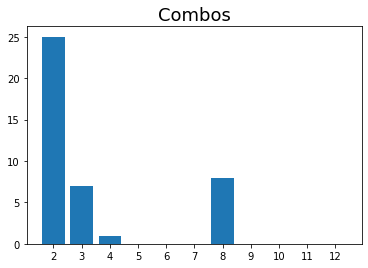

In [18]:
import matplotlib.pyplot as plt
import time
#matplotlib inline
plt.ion()
from IPython import display
#obs = env.reset()
# for i in range(5000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     if dones:
#         env.reset()
obs = env.reset()
max_round = 50
current_episode = 0
win_episodes = []
combos={i: 0 for i in range(2,13)}
golbal_dict = {"last_combo_num" : 0 }
def eval_callback2(info,golbal,dones) -> None:
    """
    Renders the environment in its current state, recording the screen in the captured `screens` list

    :param _locals: A dictionary containing all local variables of the callback's scope
    :param _globals: A dictionary containing all global variables of the callback's scope
    """
    # statistic combos
    combo_num = info["2P_combo"]
    if combo_num == 0 and golbal["last_combo_num"] is not None and golbal["last_combo_num"] > 0:
        combos[golbal["last_combo_num"]] +=1
    golbal["last_combo_num"] = combo_num


    # statistic win_loss
    if dones:
        print(info.get("win_loss") )
        if info.get("win_loss") == "WIN":
            win_episodes.append(current_episode)
for _ in range(100000000):
    display.clear_output(wait=True)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.2
    img = env.render()
    #cv2.imshow("env",img)
    action = env.action_space.sample()
    #action, _states = model.predict(obs, deterministic=True)
    # print(f"action: {action}")

    observation, reward,done, info =env.step(action) # take a random action
    eval_callback2(info,golbal_dict,done)
    #observation, reward,done, info =env.step(0)
    # plt.imshow(img)
    # plt.pause(0.1)
    # plt.clf()

    # cv2.waitKey(0)

    if done:
        current_episode +=1
        env.reset()
        if current_episode>=max_round:
            break
#env.close()
print(mean_reward,std_reward)
print(win_episodes)
print(combos)

figure = plt.figure()
#plt.bar(myDictionary.keys(), myDictionary.values(), width, color='g')
names = list(combos.keys())
values = list(combos.values())
# plt.bar(range(len(data)), values, tick_label=names)
figure.add_subplot().bar(names, values, tick_label=names, )
plt.title('Combos', fontsize=18)
# Close the figure after logging it
print(figure)
len(win_episodes)/10

1P act:37, health: 78, loc:(44,0), energy 20, reward:-0.01
2P act:1, health: 103, loc:(148,0), energy 0 ,toward:0


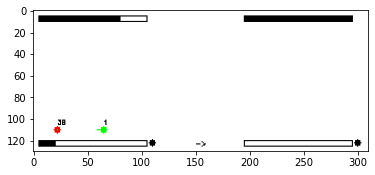

b'\x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[M

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import time
#matplotlib inline
plt.ion()
from IPython import display
#obs = env.reset()
# for i in range(5000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     if dones:
#         env.reset()
obs = env.reset()
for _ in range(1000):
    display.clear_output(wait=True)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.2
    img = env.render()
    #cv2.imshow("env",img)
    # action = env.action_space.sample()
    action, _states = model.predict(obs, deterministic=True)
    # print(f"action: {action}")

    observation, reward,done, info =env.step(action) # take a random action
    #observation, reward,done, info =env.step(0)
    plt.imshow(img)
    plt.pause(0.1)
    plt.clf()

    # cv2.waitKey(0)
    if done:
        env.reset()
env.close()


In [56]:
import matplotlib.pyplot as plt
import time
#matplotlib inline
plt.ion()
from IPython import display
for _ in range(1000):
    # display.clear_output(wait=True)
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # fontScale = 0.2

    #cv2.imshow("env",img)
    action = env.action_space.sample()
    # print(f"action: {action}")
    observation, reward,done, info =env.step(env.action_space.sample()) # take a random action
    if info["2P_combo"] > 0:
        print("1111111111111111111111111111111111111111111111111111111111111111111111111")
        env.render("other")
    #observation, reward,done, info =env.step(0)
    # plt.imshow(img)
    # plt.pause(0.1)
    # plt.clf()

    # cv2.waitKey(0)
    if done:
        env.reset()
env.close()

0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 5 5
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944

In [111]:
def int_to_b_array(value):
    return [int(x) for x in bin(value)[2:].zfill(8)]
res = []
for i in range(4,0,-1):
    action_seq = info["action_seq_"+str(i)]
    print(hex(action_seq))
    for _ in range(0,8):
        res.append(action_seq%64)
        action_seq = action_seq >>8
        #print(hex(action_seq))
print(res)
print(len(res))
binary_res = []
last_action = None
same_count = 0
keeped_count = 0
for action in res:
    if keeped_count>=12:
        break
    if action == last_action and same_count<=2:
        same_count +=1
    else:
        binary_res.append(int_to_b_array(action))
        same_count = 0
        keeped_count += 1
    last_action = action
#binary_res.reverse()
for i in range(len(binary_res),12):
    binary_res.append([0,0,0,0,0,0,0,0])
print(binary_res)
print(len(binary_res))
r= np.array(binary_res).flat
print(list(r))
print(len(r))
obs = [1 ,2 ,3]
obs = np.append(obs,r)
print(obs)

0x2101050012004000
0x2505050426044501
-0x7f7f79fbcbfb79fc
0x1400410119000600
[0, 0, 0, 18, 0, 5, 1, 33, 1, 5, 4, 38, 4, 5, 5, 37, 4, 6, 4, 52, 4, 6, 0, 0, 0, 6, 0, 25, 1, 1, 0, 20]
32
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1]]
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
96
[1 2 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1]


In [134]:
from stable_baselines3.common.env_checker import check_env

# It will check your custom environment and output additional warnings if needed
check_env(env)

In [17]:
print(env.action_space)

Discrete(49)


In [16]:
  # delete trained model to demonstrate loading

# Load the trained agent
# NOTE: if you have loading issue, you can pass `print_system_info=True`
# to compare the system on which the model was trained vs the current one
# model = DQN.load("dqn_lunar", env=env, print_system_info=True)
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
model = PPO.load("Kof97_CH0_1", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=3)

# Enjoy trained agent
#obs = env.reset()
# for i in range(5000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     if dones:
#         env.reset()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
2 2.718281828459045 4 10.87312731383618

In [18]:
for i in range(5000):
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = env.step(action)
    if dones:
        env.reset()

0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944

In [9]:
print(mean_reward, std_reward)

53.363 9.591000000000001


In [61]:
import sys
sys.modules[__name__]
try:
  gym.envs.register(
      id='kof97',
      entry_point='__main__:Kof98Environment',
      max_episode_steps=6000000
  )
except:
    pass

In [71]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from multiprocessing import Process, freeze_support, set_start_method
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

print(__name__)

if __name__ == '__main__':
    freeze_support()
    set_start_method('forkserver',force=True)
    env_id = "kof97"
    num_cpu = 1  # Number of processes to use
    # Create the vectorized environment
    env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

    model = PPO('CartPole-v1', env, verbose=1)
    model.learn(total_timesteps=25_000)

    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()

__main__


ConnectionResetError: [Errno 104] Connection reset by peer